In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Image Classification with Convolutional Neural Network

## Fashion-MNIST dataset 

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [3]:
# Some basic parameters
inpDir = '../..\Classwork/input'
outDir = './output'
subDir = 'fashion_mnist'
modelDir = './models'
logDir = './logs'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production


EPOCHS = 200 # number of cycles to run
ALPHA = 0.001 # learning rate
BATCH_SIZE = 32

PATIENCE = 20
LR_PATIENCE = 10  ## half of patience
LR_FACTOR = 0.1

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'medium',
          'figure.figsize'  : (9,9),
          'axes.labelsize'  : 'medium',
          'axes.titlesize'  :'large',
          'xtick.labelsize' :'medium',
          'ytick.labelsize' :'medium',
         }

plt.rcParams.update(params) # update rcParams
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Load Fashion MNIST dataset and visualization

In [4]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

<Axes: xlabel='label'>

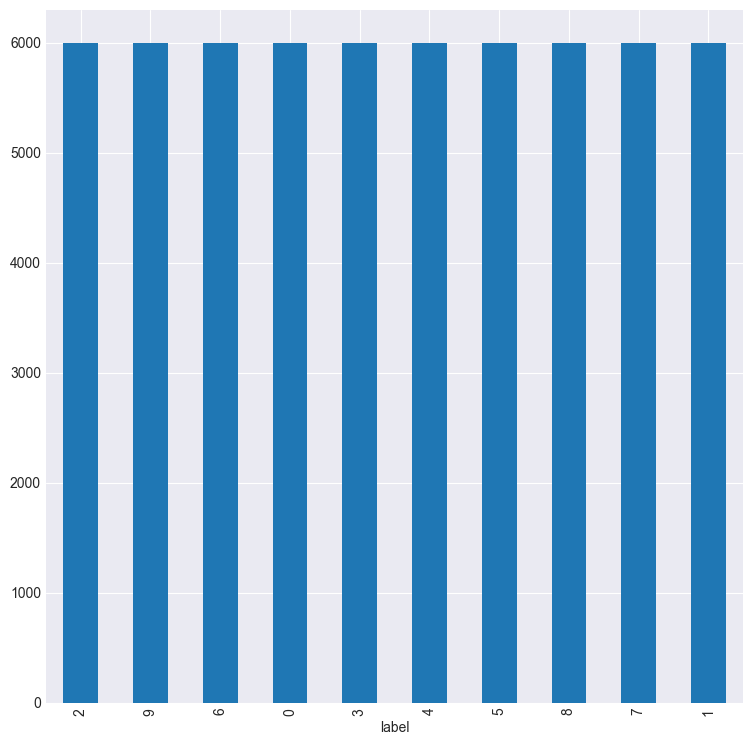

In [5]:
train_df['label'].value_counts().plot(kind = 'bar')

In [6]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

class_names = {0: 'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',
               5:'Sandal', 6: 'Shirt',7: 'Sneaker', 8:'Bag', 9: 'Ankle boot'}

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

## Explore the data

In [7]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
train_df.shape, test_df.shape

((60000, 785), (10000, 785))

## Feature Extraction and Reshaping to tensor

In [9]:
def split_feature_label(row):
    feature = tf.reshape(row[1:], [28,28,1])
    label = row[0]
    return feature, label

In [10]:
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)
train_ds = tmp_ds.map(split_feature_label)
train_ds = train_ds.batch(BATCH_SIZE)

tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)
test_ds = tmp_ds.map(split_feature_label)
test_ds = test_ds.batch(BATCH_SIZE)

## Visualization of data

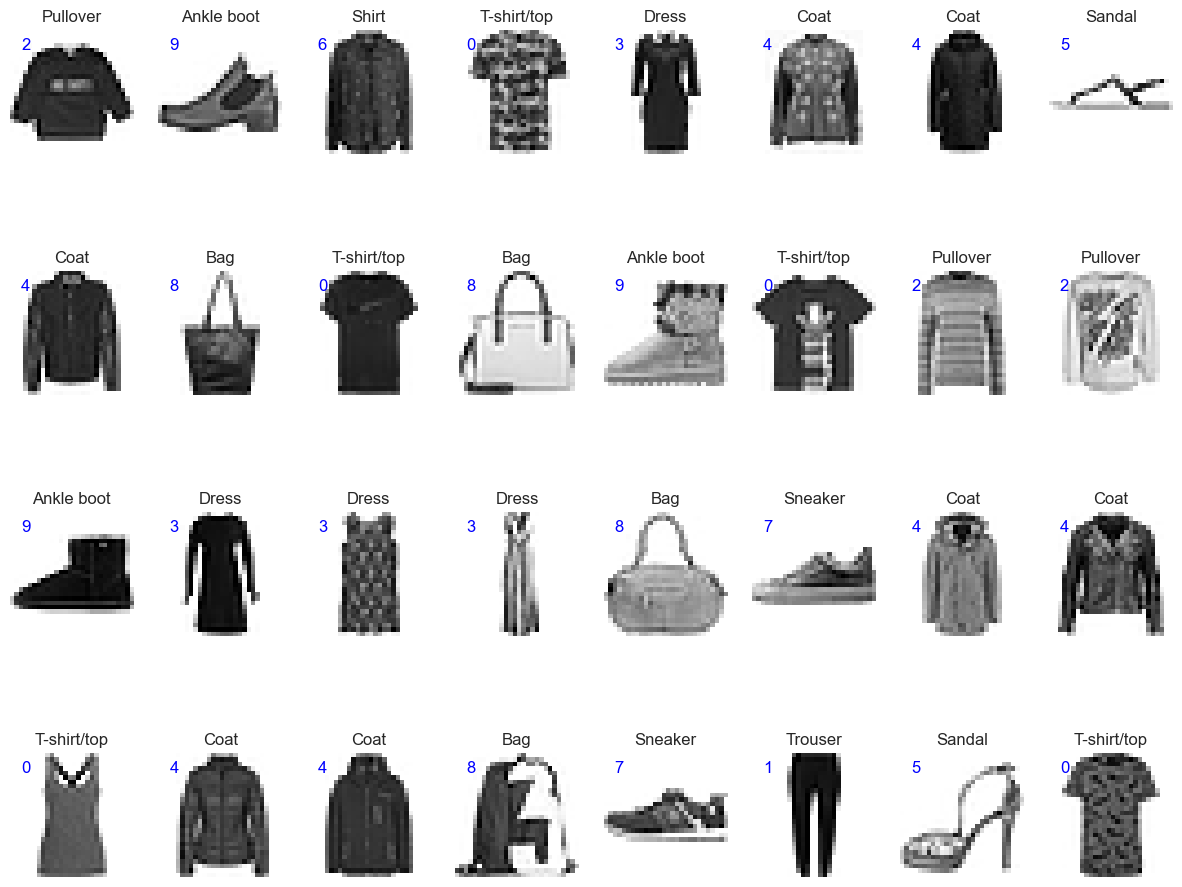

In [11]:
# Sample data plot

fig = plt.figure(figsize=(15, 12))  # figure size in inches

for images, labels in train_ds.take(1):
    
    for i in range (BATCH_SIZE):

        plt.subplot(4,int(BATCH_SIZE//4),i+1) # adjust subplots
    
        plt.imshow(images[i].numpy().astype('uint16'), 
                   cmap=plt.cm.binary, 
                   interpolation='nearest') # show image on the axis
    
        plt.title(class_names[labels[i].numpy()])   # add number (class) of the image
    
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)   # add name of the image
        
        plt.axis('off')
    
    plt.show()

In [12]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

## Model Building

In [13]:
reg_lambda = 0.005

#knl_reg = tf.keras.regularizers.L2(reg_lambda)
knl_reg = None

model = tf.keras.Sequential()

## preprocessing (scaling)
model.add(tf.keras.layers.Rescaling(1./255.))

## 1 layer
model.add(tf.keras.layers.Conv2D(32,(3,3),
                                 padding= 'same',
                                 activation = 'relu',
                                 kernel_regularizer = knl_reg,
                                 input_shape = (28,28,1))) ## output shape expected - 28*28*32

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) ## 14*14*32 

## 2 layer
model.add(tf.keras.layers.Conv2D(64,3,
                                 kernel_regularizer = knl_reg,
                                 activation = 'relu')) ## output shape expected - 12*12*64

model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2))) ## 6*6*64

## 3 layer
model.add(tf.keras.layers.Conv2D(128,(3,3),
                                 activation = 'relu',
                                 kernel_regularizer = knl_reg)) ## output shape expected - 4*4*128


## Head
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation = 'relu',kernel_regularizer = knl_reg))
model.add(tf.keras.layers.Dense(10))

In [14]:
checkpoint_path = os.path.join(modelDir, subDir, 'weights_tf_FashionMNIST')

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor='val_loss',
    verbose=2,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    initial_value_threshold=None
)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=PATIENCE,
    verbose=2,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    mode='auto',
    min_delta=0.00001,
    cooldown=0,
    min_lr=0.0,
)


In [15]:
model.compile(optimizer = tf.keras.optimizers.AdamW(), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics = ['accuracy'])

history = model.fit(train_ds, validation_data = test_ds ,
                    batch_size = BATCH_SIZE, epochs = EPOCHS, verbose=2,
                   callbacks=[model_checkpoint,es_callback,lr_callback])

Epoch 1/200



Epoch 1: val_loss improved from inf to 0.33308, saving model to ./models\fashion_mnist\weights_tf_FashionMNIST
1875/1875 - 31s - loss: 0.4377 - accuracy: 0.8400 - val_loss: 0.3331 - val_accuracy: 0.8764 - lr: 0.0010 - 31s/epoch - 17ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.33308 to 0.27483, saving model to ./models\fashion_mnist\weights_tf_FashionMNIST
1875/1875 - 24s - loss: 0.2837 - accuracy: 0.8956 - val_loss: 0.2748 - val_accuracy: 0.9007 - lr: 0.0010 - 24s/epoch - 13ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.27483 to 0.25298, saving model to ./models\fashion_mnist\weights_tf_FashionMNIST
1875/1875 - 24s - loss: 0.2355 - accuracy: 0.9137 - val_loss: 0.2530 - val_accuracy: 0.9082 - lr: 0.0010 - 24s/epoch - 13ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.25298 to 0.25205, saving model to ./models\fashion_mnist\weights_tf_FashionMNIST
1875/1875 - 24s - loss: 0.2002 - accuracy: 0.9266 - val_loss: 0.2521 - val_accuracy: 0.9090 - lr: 0.001

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         7

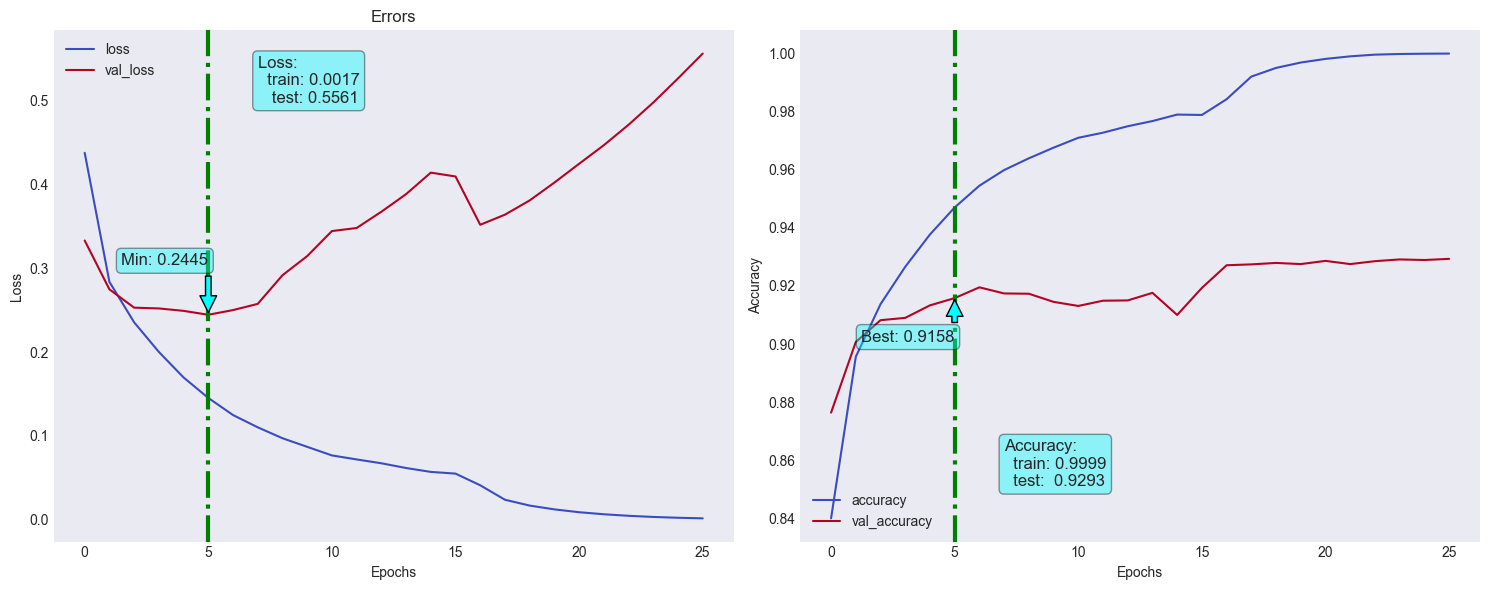

In [17]:
fn_plot_tf_hist(pd.DataFrame(history.history))